In [37]:
import torch

from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#### <center>Device</center>

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(device)

cpu


### <center> Download the training and testing datasets </center>

In [ ]:
train_data = datasets.MNIST(
    root='data',
    train = True,
    transform=ToTensor(),
    download=True
)

test_data = datasets.MNIST(
    root='data',
    train = False,
    transform=ToTensor(),
    download=True
)

In [47]:
test_data.data.shape
#train_data.data.shape

torch.Size([10000, 28, 28])

#### Data Loader

In [39]:
data_loader = {
    'train': DataLoader(train_data, batch_size = 100, shuffle=True),
    'test': DataLoader(test_data, batch_size = 100, shuffle=True)
}

## <center>CNN Class</center>

In [40]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        self.conv_layers = nn.Sequential (
            nn.Conv2d(1, 16, kernel_size=3, padding=1),  # -> 16x28x28
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                          # -> 16x14x14

            nn.Conv2d(16, 32, kernel_size=3, padding=1), # -> 32x14x14
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                          # -> 32x7x7

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # -> 64x7x7
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                          # -> 64x3x3
        )

        # Dropout layers, disable 1/4 neurons or feature maps for less overfitting
        self.dropout2d = nn.Dropout2d(0.25) # conv_layers
        self.dropout = nn.Dropout(0.25) # fcl layers

        self.fc1 = nn.Linear(64 * 3 * 3, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 classes for MNIST digits

    
    def forward(self, x):
        x = self.conv_layers(x) # Conv layers
        x = self.dropout2d(x)

        x = x.flatten(start_dim = 1) # Flatten to 1D tensor so if 28x28 -> 1D tensor of 784
        x = F.relu(self.fc1(x))

        x = self.dropout(x)
        x = self.fc2(x)
        return x
    

### Creating the Actual Model & Training Loop

In [ ]:
model = Net().to(device)

optimizer = optim.Adam(model.parameters(), lr = 0.001)
#optimizer = optim.SGD(model.parameters(), lr = 0.001)

# "log loss"
loss_func = nn.CrossEntropyLoss() # Has softmax built in, no need to use softmax before CEL

In [42]:
# ------TRAINING LOOP------- :D
def train(num_epochs):

    model.train()

    for epoch in range(num_epochs):
        total_loss = 0

        for batch_idx, (data, target) in enumerate(data_loader['train']):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad() # Clear old gradients
            output = model(data) # Compute predictions

            # CROSS ENTROPY LOSS ^^^
            loss = loss_func(output, target)
            loss.backward() # Backprop for gradients
            
            optimizer.step() # Update weights based on gradients

            total_loss+=loss.item()

        # Avg loss per batch (totalLoss/numBatches)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(data_loader['train']):.2f}")


#### <center>TRAINING THE MODEL</center>

In [43]:
train(num_epochs=15)

Epoch [1/15], Loss: 0.33
Epoch [2/15], Loss: 0.10
Epoch [3/15], Loss: 0.07
Epoch [4/15], Loss: 0.06
Epoch [5/15], Loss: 0.05
Epoch [6/15], Loss: 0.04
Epoch [7/15], Loss: 0.04
Epoch [8/15], Loss: 0.03
Epoch [9/15], Loss: 0.03
Epoch [10/15], Loss: 0.03
Epoch [11/15], Loss: 0.03
Epoch [12/15], Loss: 0.02
Epoch [13/15], Loss: 0.02
Epoch [14/15], Loss: 0.02
Epoch [15/15], Loss: 0.02


### <center>Visualizing predictions!</center>

In [34]:
import matplotlib.pyplot as plt

def show_pred(model, dataloader, device, num_images):
    model.eval()

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images) # logits/raw output

            preds = outputs.argmax(dim = 1)

            fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2.5, 3))

            for i in range(num_images):
                img = images[i].cpu().squeeze() # Removes channel dim -> 28x28

                ax = axes[i]
                ax.imshow(img, cmap = 'gray')
                
                # Mark incorrect predictions w/ color red for easier identification
                plot_color = 'red' if preds[i] != labels[i] else 'black'

                ax.set_title(f'Prediction: {preds[i].item()} \n Actual: {labels[i].item()}', color = plot_color)
                ax.axis('off')

            break

plt.show()


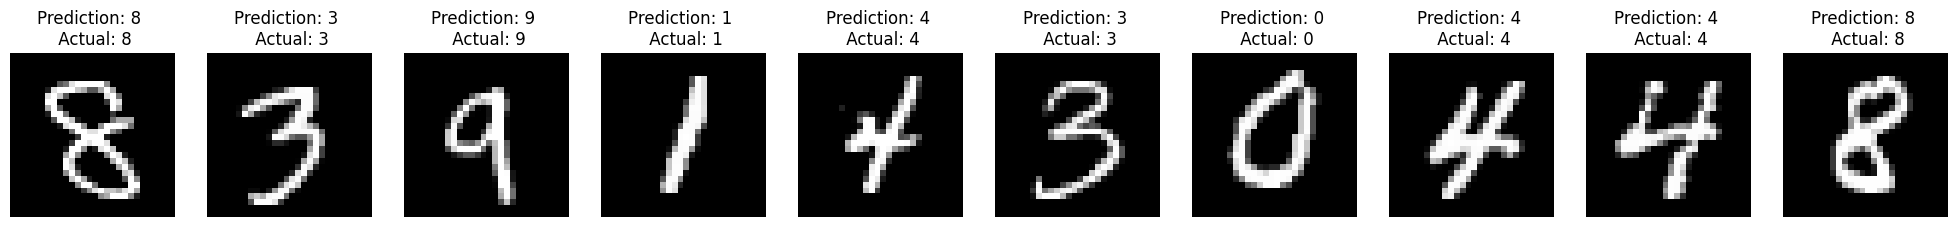

In [50]:
show_pred(model, data_loader['test'], device, 10)